In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_file_path = "../data/raw/MyPileupHistogram.root"
mc_file_path = "../data/processed_datasets/Processed_Z2JetsToNuNu_PtZ-150To250_*.csv"

In [3]:
# Open the ROOT file containing the pileup histogram from real data
file_data = uproot.open(data_file_path)
hist_data = file_data["pileup"]

# Extract the histogram values (heights of each bin)
data_values = hist_data.values()  
bins = hist_data.axis().edges()  

# Normalize the data histogram so the area under the curve is 1
data_values /= np.sum(data_values) 

In [4]:
# Load the Monte Carlo data from CSV
mc_df = pd.read_csv(mc_file_path)

# Extract the pileup values from the MC events
nPU_mc = mc_df["pileup"].values
mc_values, _ = np.histogram(nPU_mc, bins=bins)

# Normalize the MC histogram
mc_values = mc_values / np.sum(mc_values)

In [5]:
# Compute pileup correction weights: data / MC
weights_pileup = np.divide(data_values, mc_values, out=np.ones_like(data_values), where=mc_values != 0)

In [6]:
# Assign the corresponding pileup weight to each MC event
mc_df["pileup_weight"] = [weights_pileup[np.digitize(n, bins) - 1] if np.digitize(n, bins) - 1 < len(weights_pileup) else 1 for n in nPU_mc]

Uses np.digitize to identify which bin the pileup value belongs to, then retrieves the corresponding weight from the weights_pileup array, which was computed as the ratio between the real data pileup distribution and the Monte Carlo (MC) distribution. If the pileup value falls outside the defined bin range, a default weight of 1 is assigned. This procedure adjusts the pileup distribution in the MC to better match that of the real data, ensuring more accurate comparisons and analyses.

In [7]:
# If the MC already has a weight column (e.g. genWeight), multiply by the pileup weight
if "weight" in mc_df.columns:
    mc_df["final_weight"] = mc_df["weight"] * mc_df["pileup_weight"]
else:
    mc_df["final_weight"] = mc_df["pileup_weight"]

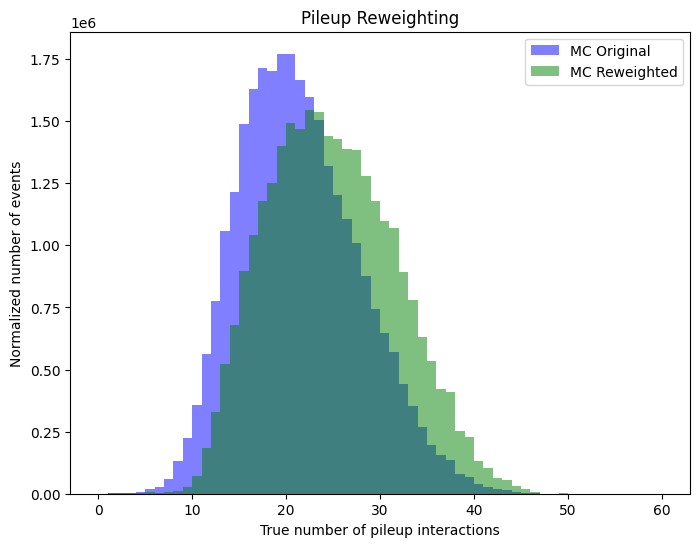

In [8]:
# Plot the original and reweighted pileup distributions
plt.figure(figsize=(8, 6))
plt.hist(nPU_mc, bins=bins, weights=mc_df["weight"], alpha=0.5, label="MC Original", color="blue")
plt.hist(nPU_mc, bins=bins, weights=mc_df["final_weight"], alpha=0.5, label="MC Reweighted", color="green")
plt.xlabel("True number of pileup interactions")
plt.ylabel("Normalized number of events")
plt.legend()
plt.title("Pileup Reweighting")
plt.show()